In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

In [2]:
# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import pandas as pd

from ylearn.estimator_model.meta_learner import SLearner, TLearner, XLearner
from ylearn.estimator_model.doubly_robust import DoublyRobust
from ylearn.utils import to_df
%matplotlib inline


In [3]:
v = np.random.normal(size=(1000, 10))
y = np.hstack([v[:, [0]] < 0, v[:, [0]] > 0])

data = to_df(v=v)
covariate = data.columns

In [4]:
from ylearn.effect_interpreter.policy_interpreter import PolicyInterpreter
pit = PolicyInterpreter(max_depth=2)
pit.fit(data=data, est_model=None, covariate=covariate, effect_array=y.astype(float))

pit_result = pit.interpret()

06-02 17:06:49 I ylearn.p.policy_model.py 448 - Start building the policy tree with criterion PRegCriteria
06-02 17:06:49 I ylearn.p.policy_model.py 464 - Building the policy tree with splitter BestSplitter
06-02 17:06:49 I ylearn.p.policy_model.py 507 - Building the policy tree with builder DepthFirstTreeBuilder


In [5]:
for i in range(57, 60):
    print(f'the policy for the sample {i}\n --------------\n' + pit_result[f'sample_{i}'] + '\n')

the policy for the sample 57
 --------------
decision node 0: (covariate [57, 0] = 0.2884798049926758) > 1.5298370271921158e-05 
decision node 2: (covariate [57, 5] = -0.5899866223335266) > -3.1488250494003296 
The recommended policy is treatment 1 with value 1.0

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 0] = 0.3903595507144928) > 1.5298370271921158e-05 
decision node 2: (covariate [58, 5] = 0.6641703844070435) > -3.1488250494003296 
The recommended policy is treatment 1 with value 1.0

the policy for the sample 59
 --------------
decision node 0: (covariate [59, 0] = 0.007665162906050682) > 1.5298370271921158e-05 
decision node 2: (covariate [59, 5] = -0.9592787623405457) > -3.1488250494003296 
The recommended policy is treatment 1 with value 1.0



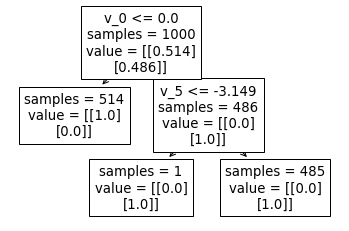

In [6]:
pit.plot()
plt.show()

In [7]:
from ylearn.estimator_model.double_ml import DML4CATE

In [8]:
X = np.random.normal(size=(1000, 10))
T = np.random.binomial(2, .5, size=(1000,))
y = (X[:, 0]) * (T==1) + (-X[:, 0]) * (T==2) 
dt = to_df(v=X, treatment=T, outcome=y)
covariate = dt.columns[:10]

In [9]:
xl = XLearner(model=RandomForestRegressor())
xl.fit(data=dt, outcome='outcome', treatment='treatment', covariate=covariate)

XLearner

In [10]:
pit1 = PolicyInterpreter(max_depth=2)
pit1.fit(
    data=data,
    est_model=xl,
)

06-02 17:07:27 I ylearn.p.policy_model.py 448 - Start building the policy tree with criterion PRegCriteria
06-02 17:07:27 I ylearn.p.policy_model.py 464 - Building the policy tree with splitter BestSplitter
06-02 17:07:27 I ylearn.p.policy_model.py 507 - Building the policy tree with builder DepthFirstTreeBuilder


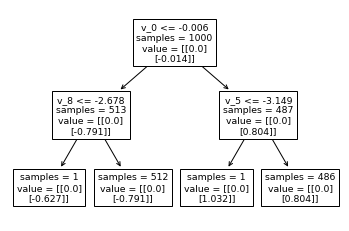

In [11]:
pit1.plot()
plt.show()

In [12]:
pit1_result = pit1.interpret()
for i in range(57, 60):
    print(f'the policy for the sample {i}\n --------------\n' + pit1_result[f'sample_{i}'] + '\n')

the policy for the sample 57
 --------------
decision node 0: (covariate [57, 0] = 0.2884798049926758) > -0.005520865088328719 
decision node 4: (covariate [57, 5] = -0.5899866223335266) > -3.1488250494003296 
The recommended policy is treatment 1 with value 0.8038919683329303

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 0] = 0.3903595507144928) > -0.005520865088328719 
decision node 4: (covariate [58, 5] = 0.6641703844070435) > -3.1488250494003296 
The recommended policy is treatment 1 with value 0.8038919683329303

the policy for the sample 59
 --------------
decision node 0: (covariate [59, 0] = 0.007665162906050682) > -0.005520865088328719 
decision node 4: (covariate [59, 5] = -0.9592787623405457) > -3.1488250494003296 
The recommended policy is treatment 1 with value 0.8038919683329303



In [13]:
dml = DML4CATE(
    x_model=RandomForestClassifier(),
    y_model=RandomForestRegressor(),
    is_discrete_treatment=True,
)
dml.fit(data=dt, outcome='outcome', treatment='treatment', covariate=covariate)

06-02 17:08:20 I ylearn.e.double_ml.py 670 - _fit_1st_stage: fitting x_model RandomForestClassifier
06-02 17:08:21 I ylearn.e.double_ml.py 676 - _fit_1st_stage: fitting y_model RandomForestRegressor
06-02 17:08:21 I ylearn.e.double_ml.py 702 - _fit_2nd_stage: fitting yx_model LinearRegression


Double Machine Learning Estimator

In [16]:
pit2 = PolicyInterpreter(max_depth=2,)
pit2.fit(
    data=dt,
    est_model=dml,
    covariate=covariate,
)
pit2_result = pit2.interpret()

for i in range(57, 60):
    print(f'the policy for the sample {i}\n --------------\n' + pit2_result[f'sample_{i}'] + '\n')

06-02 17:08:35 I ylearn.p.policy_model.py 448 - Start building the policy tree with criterion PRegCriteria
06-02 17:08:35 I ylearn.p.policy_model.py 464 - Building the policy tree with splitter BestSplitter
06-02 17:08:35 I ylearn.p.policy_model.py 507 - Building the policy tree with builder DepthFirstTreeBuilder
the policy for the sample 57
 --------------
decision node 0: (covariate [57, 0] = -2.7169482707977295) <= 0.008336803875863552 
decision node 1: (covariate [57, 0] = -2.7169482707977295) <= -0.027416213415563107 
The recommended policy is treatment 2 with value 0.745946269132653

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 0] = -0.002350178547203541) <= 0.008336803875863552 
decision node 1: (covariate [58, 0] = -0.002350178547203541) > -0.027416213415563107 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 59
 --------------
decision node 0: (covariate [59, 0] = 0.1821427196264267) > 0.008336803875863552 
decis

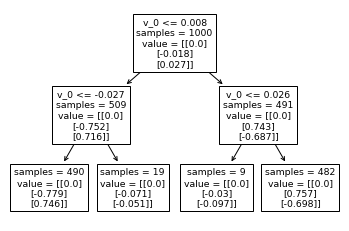

In [17]:
pit2.plot()
plt.show()

## Single binary treatment.

### The dataset is generated by the following process
Below we use the einstein notation to alleviate the headaches of specifiying dimensions of tensors.
\begin{align*}
    x & \sim \text{Bernoulli}(f(w)), \quad f(w) = \sigma(w_i \beta^i + \eta), \quad \eta\sim \text{Uniform}(-1, 1) \\
    y & = x \theta(v^i) + \gamma_j w^j + \epsilon, \quad \epsilon \sim \text{Uniform}(-1, 1)\\
    w & \sim \text{Normal}(0, I_{n_w})\\
    v & \sim \text{Uniform}(0, 1)^{n_v}
\end{align*}

In [18]:
# Define DGP
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    """Generates population data for given untreated_outcome, treatment_effect and propensity functions.
    
    Parameters
    ----------
        n (int): population size
        d (int): number of covariates
        controls_outcome (func): untreated outcome conditional on covariates
        treatment_effect (func): treatment effect conditional on covariates
        propensity (func): probability of treatment conditional on covariates
    """
    # Generate covariates
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

In [19]:
def generate_controls_outcome(d):
    beta = uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)
treatment_effect = lambda x: (1 if x[1] > 0.1 else -0.5)*8
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)
# DGP constants and test data
d = 5
n = 1000
n_test = 250
controls_outcome = generate_controls_outcome(d)
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)

In [20]:
y, x, w = generate_data(n, d, controls_outcome, treatment_effect, propensity)
data_dict = {
    'outcome': y,
    'treatment': x,
}
test_dict = {}
adjustment = []
for i in range(w.shape[1]):
    data_dict[f'w_{i}'] = w[:, i].squeeze()
    test_dict[f'w_{i}'] = X_test[:, i].squeeze()
    adjustment.append(f'w_{i}')
outcome = 'outcome'
treatment = 'treatment'
data = pd.DataFrame(data_dict)
test_data = pd.DataFrame(test_dict)


In [21]:
t = TLearner(
    model=GradientBoostingRegressor()
)
t.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    covariate=adjustment,
)
t_pred = t.estimate(data=test_data, quantity=None)

In [22]:
from ylearn.effect_interpreter.policy_interpreter import PolicyInterpreter

In [23]:
p = PolicyInterpreter(max_depth=2)
p.fit(
    data=data,
    est_model=t,
)
policy = p.interpret(data=test_data)

06-02 17:10:03 I ylearn.p.policy_model.py 448 - Start building the policy tree with criterion PRegCriteria
06-02 17:10:03 I ylearn.p.policy_model.py 464 - Building the policy tree with splitter BestSplitter
06-02 17:10:03 I ylearn.p.policy_model.py 507 - Building the policy tree with builder DepthFirstTreeBuilder


In [24]:
for i in range(60, 62):
    print(f'the policy for the sample {i}\n --------------\n' + policy[f'sample_{i}'] + '\n')

the policy for the sample 60
 --------------
decision node 0: (covariate [60, 1] = -1.559999942779541) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 61
 --------------
decision node 0: (covariate [61, 1] = -1.5360000133514404) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0



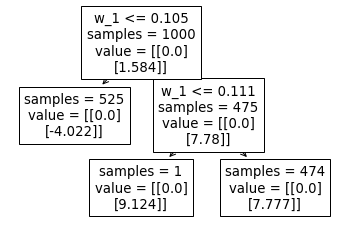

In [25]:
p.plot()
plt.show()

In [26]:
for i in range(55, 60):
    print(f'the policy for the sample {i}\n --------------\n' + policy[f'sample_{i}'] + '\n')

the policy for the sample 55
 --------------
decision node 0: (covariate [55, 1] = -1.6799999475479126) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 56
 --------------
decision node 0: (covariate [56, 1] = -1.656000018119812) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 57
 --------------
decision node 0: (covariate [57, 1] = -1.6319999694824219) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 1] = -1.6080000400543213) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 59
 --------------
decision node 0: (covariate [59, 1] = -1.5839999914169312) <= 0.10498382151126862 
The recommended policy is treatment 0 with value 0.0

